# **Text Summarization with Encoder-Decoder and Attention**

## **1. Pendahuluan**

Proyek ini bertujuan untuk membangun text summarization berbasis **arsitektur Encoder-Decoder** yang dilengkapi dengan mekanisme **Attention LSTM**.

Dataset yang digunakan berupa **ulasan dari Universitas Bengkulu beserta ringkasannya**.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Configurations
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **2. Data Preprocessing**
Dataset ini terdiri dari dua kolom: `text` (ulasan lengkap) dan `summary` (ringkasan ulasan).  

Data akan dibersihkan dari karakter yang tidak diperlukan, ditokenisasi, dan dipersiapkan untuk model.




### **Load Dataset**

In [ ]:
# Dataset is a collection of reviews and summaries.
url = "https://github.com/search01/UAS_DeepLearning/blob/main/Dataset.xlsx"
df = pd.read_excel(url)

df.head()

,text,summary
0,"Tiap tahun semakin bagus dan banyak perubahan,...",semakin bagus banyak perubahan jaya terus unib
1,Tolong dech tingkatkan lagi pelayanan publikny...,Pelayanan publik dan administrasi perlu diting...
2,"Sungguh luar biasa, area belajar UNIB sungguh ...","Area belajar di UNIB sangat luas, rindang, dan..."
3,"Ketika saya berkunjung ke sini, kondisinya kam...","Saat berkunjung, kampus sedang tutup karena li..."
4,"Kampusnya luas dan asri, semoga fasilitas dan ...","Kampus luas dan asri, diharapkan fasilitas dan..."


In [ ]:
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(axis=0, inplace=True)

print("Dataset loaded successfully.")
print(f"Number of samples: {len(df)}")

Dataset loaded successfully.
Number of samples: 211


### **Text Cleaning**
- Menghapus tag HTML menggunakan **BeautifulSoup**.  
- Melakukan tokenisasi teks dan menyaring token yang bukan alfanumerik.  
- Menghilangkan *stopwords* untuk memfokuskan pada kata-kata yang lebih bermakna.

In [ ]:
stop_words = set(stopwords.words('indonesian'))

In [ ]:
def clean_text(text, is_target=False):
    """Clean text for preprocessing."""
    text = BeautifulSoup(text, "lxml").text  # Remove HTML
    words = word_tokenize(text.lower())  # Tokenize
    words = [word for word in words if word.isalpha() and word not in stop_words]
    if is_target:
        return "sos " + " ".join(words) + " eos"
    return " ".join(words)

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_summary'] = df['summary'].apply(lambda x: clean_text(x, is_target=True))

In [ ]:
# Split into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['cleaned_summary'], test_size=0.1, random_state=42
)

Mengubah teks menjadi urutan bilangan bulat, di mana setiap kata direpresentasikan oleh indeks dalam kosakata.  
- **Padding** digunakan untuk memastikan semua urutan memiliki panjang yang sama dengan menambahkan angka nol pada urutan yang lebih pendek.

In [ ]:
# Tokenization and Padding
input_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

input_tokenizer.fit_on_texts(x_train)
target_tokenizer.fit_on_texts(y_train)

x_train_seq = input_tokenizer.texts_to_sequences(x_train)
y_train_seq = target_tokenizer.texts_to_sequences(y_train)

max_in_len = max(len(seq) for seq in x_train_seq)
max_out_len = max(len(seq) for seq in y_train_seq)

x_train_padded = pad_sequences(x_train_seq, maxlen=max_in_len, padding='post')
y_train_padded = pad_sequences(y_train_seq, maxlen=max_out_len, padding='post')

In [ ]:
# Decoder input and target preparation
decoder_input_data = y_train_padded[:, :-1]
decoder_target_data = y_train_padded[:, 1:]

In [ ]:
# Vocabulary sizes
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

## **3. Model Definition**
Model Encoder-Decoder akan dibangun dengan mekanisme perhatian (*attention*).  
- **Encoder** memproses urutan input dan menghasilkan *context vector*.  
- **Decoder** menghasilkan urutan output secara bertahap, satu kata dalam satu waktu.

In [ ]:
latent_dim = 256

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_in_len,))
encoder_embedding = Embedding(input_vocab_size, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

In [ ]:
# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, *_ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

In [ ]:
# Attention Mechanism
attention_layer = Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
concat_outputs = Concatenate(axis=-1)([decoder_outputs, attention_outputs])

In [ ]:
# Dense Layer
decoder_dense = Dense(target_vocab_size, activation='softmax')
final_outputs = decoder_dense(concat_outputs)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 39)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 39, 256)        │        144,128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │        114,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 39, 256),      │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, None, 256)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 512)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 448)      │        229,824 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,539,264 (5.87 MB)

 Trainable params: 1,539,264 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

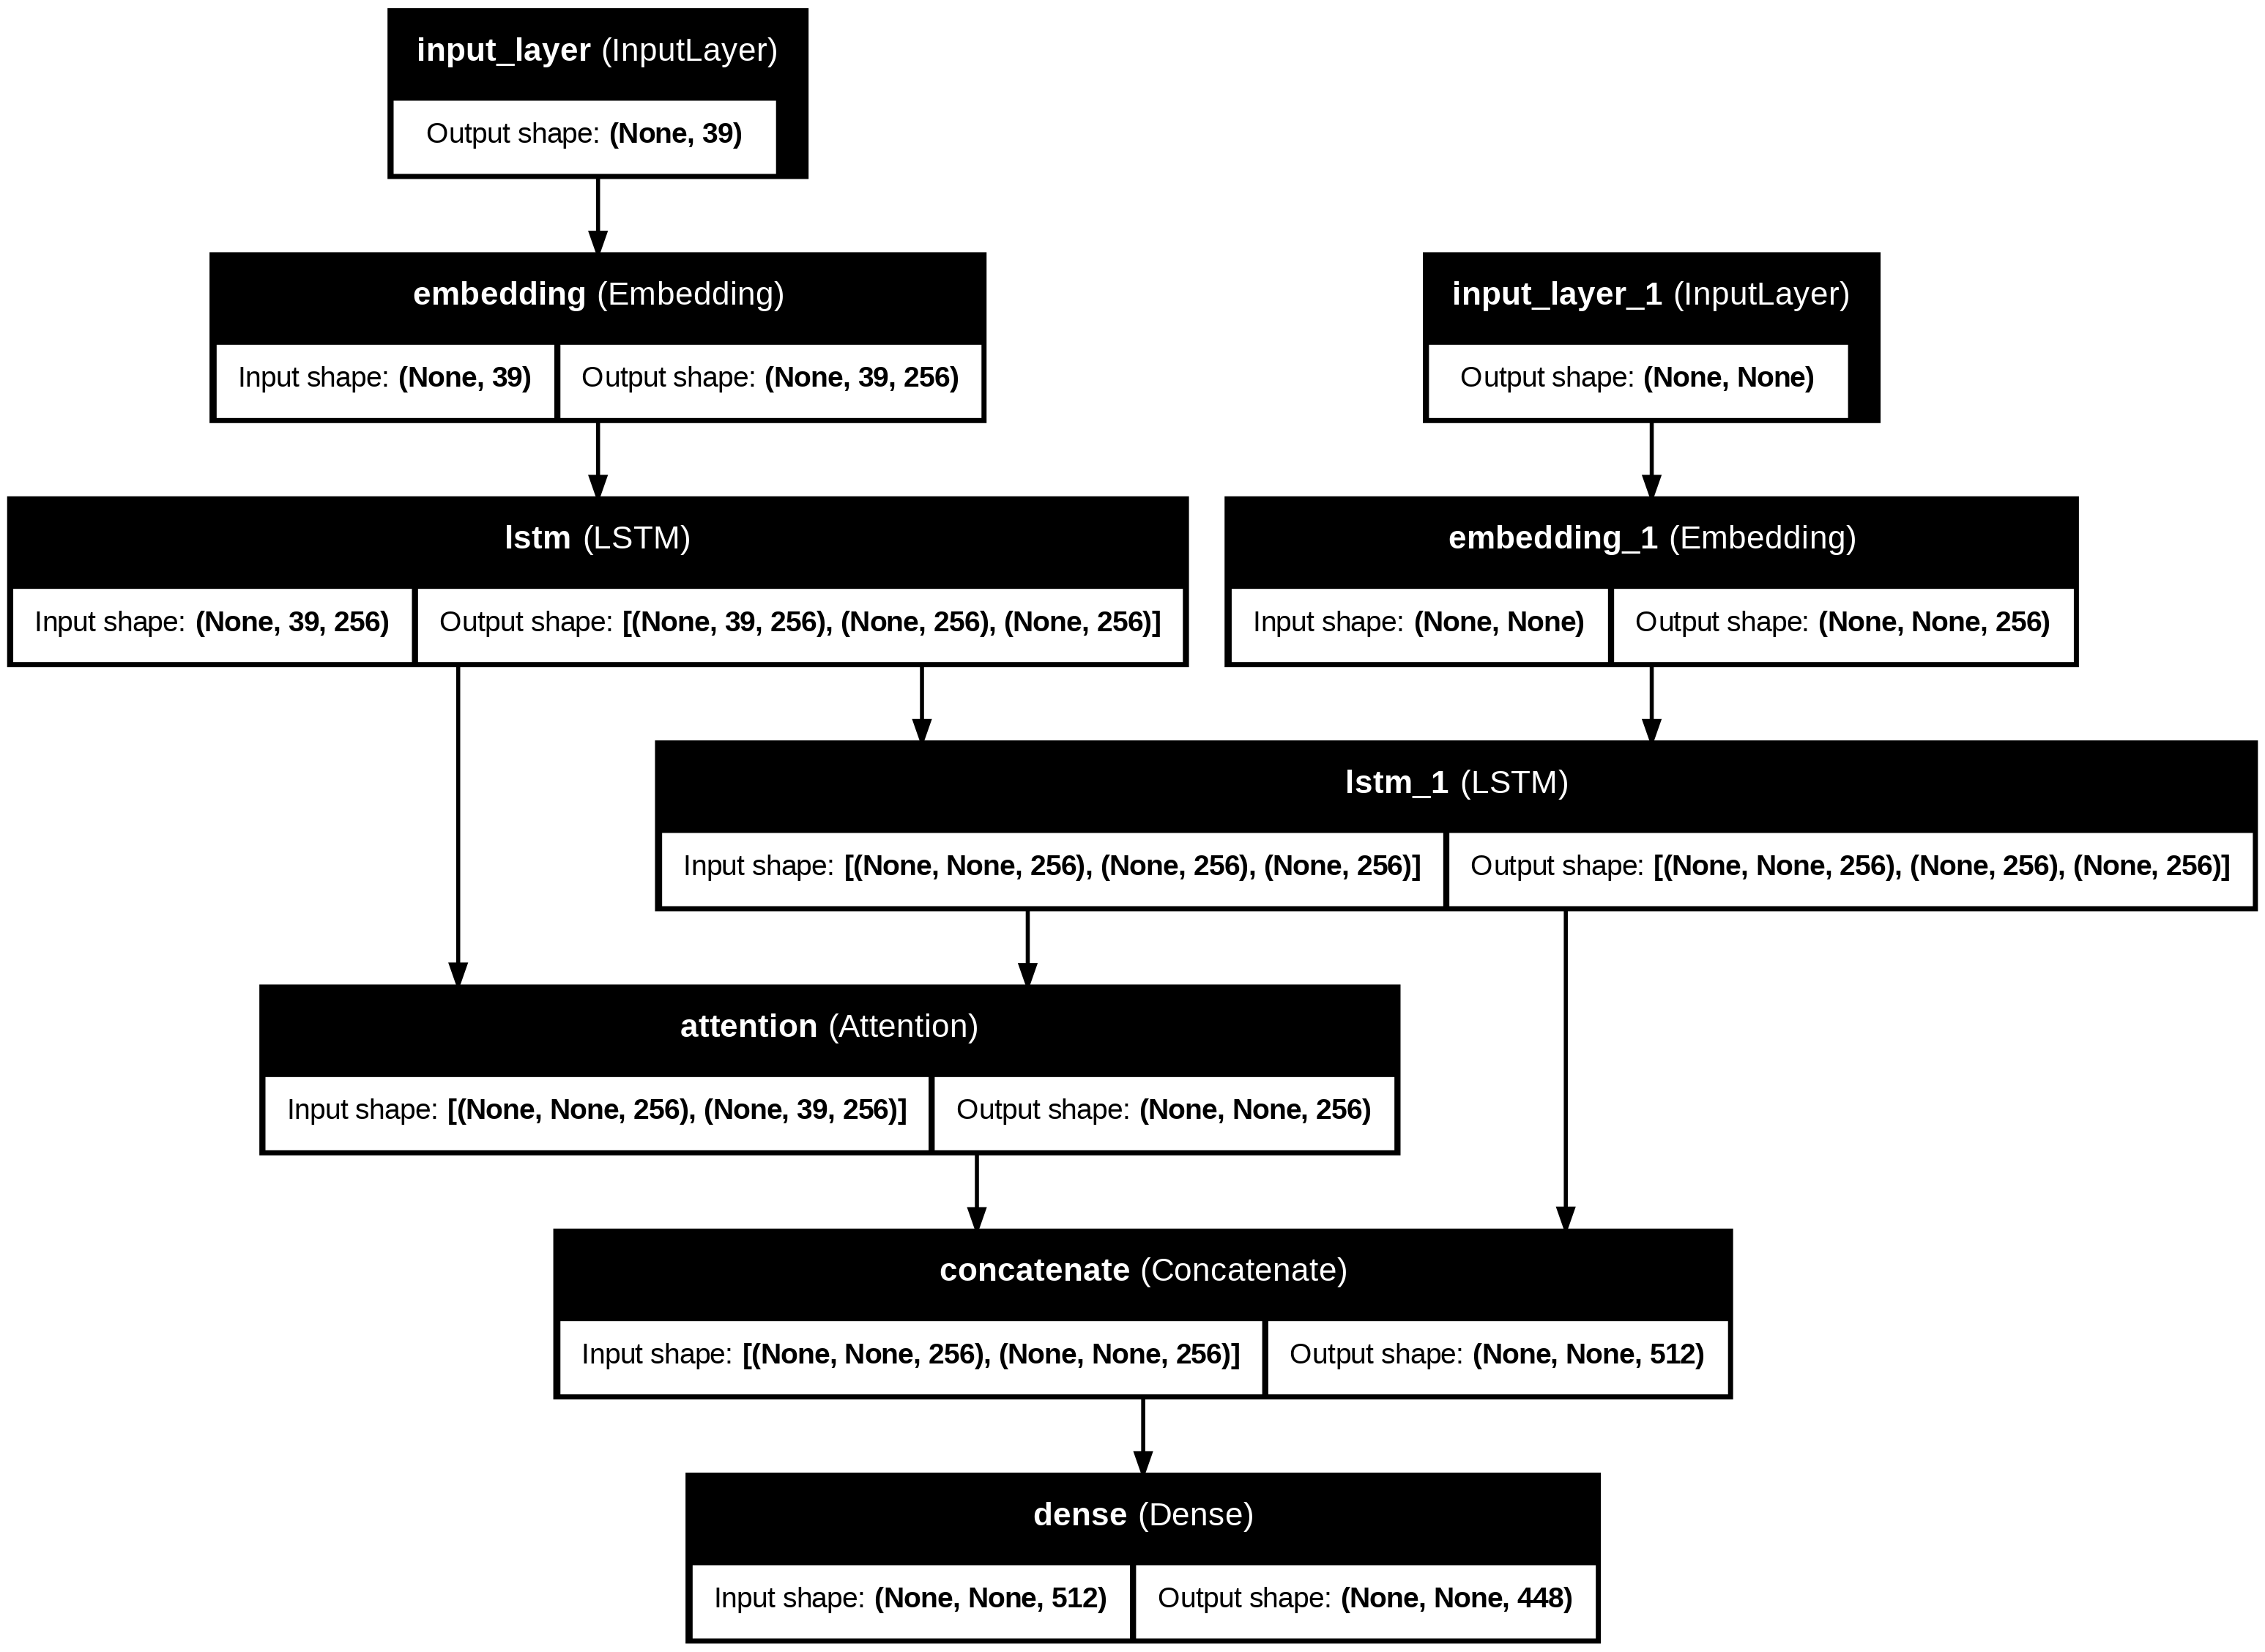

In [ ]:
# Define Model
from tensorflow.keras.utils import plot_model
model = Model([encoder_inputs, decoder_inputs], final_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **4. Training Model**
Model dilatih menggunakan dataset pelatihan dan divalidasi dengan membagi data menjadi bagian validasi.

**EarlyStopping** akan digunakan untuk mencegah *overfitting*.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    [x_train_padded, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.2852 - loss: 5.7233 - val_accuracy: 0.7093 - val_loss: 2.2171
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - accuracy: 0.7099 - loss: 2.1490 - val_accuracy: 0.7093 - val_loss: 1.7773
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.7084 - loss: 1.7316 - val_accuracy: 0.7093 - val_loss: 1.6751
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step - accuracy: 0.7159 - loss: 1.6136 - val_accuracy: 0.7177 - val_loss: 1.6662
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.7227 - loss: 1.6279 - val_accuracy: 0.7297 - val_loss: 1.6261
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.7346 - loss: 1.5318 - val_accuracy: 0.7225 - val_loss: 1.6044
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 0.7369 - loss: 1.5010 - val_accuracy: 0.7356 - val_loss: 1.6053
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.7339 - loss: 1.5123 - val_accuracy: 0.7249 - 

In [ ]:
# Save the model and tokenizers
model.save("text_summarizer_model.h5")
with open("input_tokenizer.pkl", "wb") as f:
    pickle.dump(input_tokenizer, f)
with open("target_tokenizer.pkl", "wb") as f:
    pickle.dump(target_tokenizer, f)

## **5. Evaluation**
Kurva model pada training dan validation akurasi dan loss


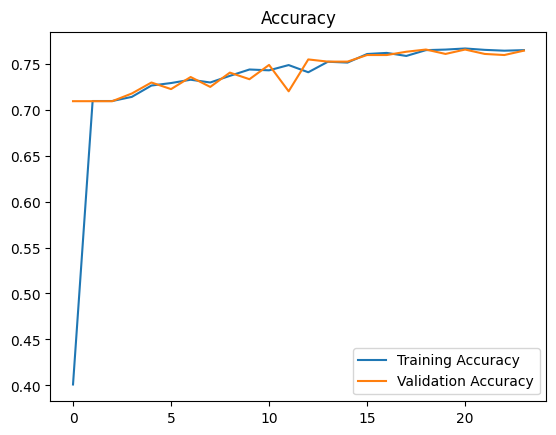

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

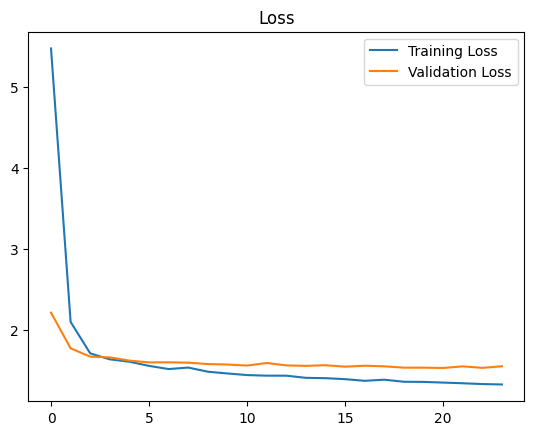

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()

## **6. Inference**

In [ ]:
# Load the model for inference
from tensorflow.keras.models import load_model
model = load_model("text_summarizer_model.h5")

In [ ]:
# Encoder model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

In [ ]:
# Decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_in_len, latent_dim))
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
attention_outputs = attention_layer([decoder_outputs, decoder_hidden_state_input])
concat_outputs = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
decoder_outputs = decoder_dense(concat_outputs)
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs, state_h, state_c]
)

In [ ]:
# Generate Summary
def generate_summary(input_text):
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq_padded = pad_sequences(input_seq, maxlen=max_in_len, padding='post')
    encoder_out, state_h, state_c = encoder_model.predict(input_seq_padded)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_tokenizer.word_index['sos']
    stop_condition = False
    summary = ""

    while not stop_condition:
        decoder_out, state_h, state_c = decoder_model.predict(
            [target_seq, encoder_out, state_h, state_c]
        )
        word_index = np.argmax(decoder_out[0, -1, :])
        word = target_tokenizer.index_word[word_index]
        if word == "eos" or len(summary.split()) >= max_out_len:
            stop_condition = True
        else:
            summary += word + " "
            target_seq[0, 0] = word_index
    return summary.strip()

In [ ]:
# Test with an example
test_text = """
Tolong dech tingkatkan lagi pelayanan publiknya...
Tingkatkan Pelayanan adm nya,spy lbh ramah dan solutif...
Trs trg gak cocok bgt yg lg buru2 tp disuruh Nunda Ampe berhari2.
Tempat sholatnya ,air gak ada. Pdhal Suasana kampus enak bgt,bs JD tempat healing,tempat jajan,makan byk pilihan.
"""
cleaned_text = clean_text(test_text)
print("Summary:", generate_summary(cleaned_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Summary: kampus
